## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [7]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [9]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [128]:
# Inspect the dataframe to understand the given data.
df.head()


,index,type,id,score,tags,,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [12]:
# Detailed data view
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [13]:
#print the column names
print("Columns: ", df.columns.values)

Columns:  ['_index' '_type' '_id' '_score' '_source.tags' '_source.zip_code'
 '_source.complaint_id' '_source.issue' '_source.date_received'
 '_source.state' '_source.consumer_disputed' '_source.product'
 '_source.company_response' '_source.company' '_source.submitted_via'
 '_source.date_sent_to_company' '_source.company_public_response'
 '_source.sub_product' '_source.timely' '_source.complaint_what_happened'
 '_source.sub_issue' '_source.consumer_consent_provided']


In [14]:
#Assign new column names
df.rename(columns={'_index':'index',
  '_type':'type',
  '_id':'id',
  '_score':'score',
  '_source.tags':'tags',
  '_source.zip_code':'',
 '_source.complaint_id':'complaint_id',
 '_source.issue':'issue',
 '_source.date_received':'date_received',
 '_source.state':'state',
 '_source.consumer_disputed':'consumer_disputed',
 '_source.product':'product',
 '_source.company_response':'company_response',
 '_source.company':'company',
 '_source.submitted_via':'submitted_via',
 '_source.date_sent_to_company':'date_sent_to_company',
 '_source.company_public_response':'company_public_response',
 '_source.sub_product':'sub_product',
 '_source.timely':'timely',
 '_source.complaint_what_happened':'complaint_what_happened',
 '_source.sub_issue':'sub_issue',
 '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [15]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)

In [129]:
df['complaint_what_happened'].isnull().sum()

0

In [17]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [19]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_txt(txt):
  txt=txt.lower()  #convert to lower
  txt=re.sub(r'[^\w\s]',' ',txt) #Remove the punctuation
  txt=re.sub(r'^\[[\w\s]\]+$',' ',txt) #Remove text in []
  txt=re.sub(r'^[a-zA-Z]\d+\w*$',' ',txt) #Remove number words
  return txt

In [34]:
#Write your function to Lemmatize the texts
stopword = nlp.Defaults.stop_words
def lemmatize(txts):
    l_sentences = []
    for doc in tqdm(nlp.pipe(txts)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopword)]
        l_sentences.append(' '.join(sent))
    return l_sentences

In [131]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()

In [133]:
from tqdm.notebook import tqdm
tqdm.pandas()
df_clean['complaint_what_happened'] = df['complaint_what_happened'].progress_apply(lambda x: clean_txt(x))

  0%|          | 0/21072 [00:00<?, ?it/s]

In [134]:
df_clean['complaint_what_happened_lemme'] = lemmatize(df_clean['complaint_what_happened'])

0it [00:00, ?it/s]

In [135]:
# Add category and sub_category columns for topic modelling
df_clean['cat'] = df['product']
df_clean['sub_cat'] = df['sub_product']

In [136]:
#Write your function to extract the POS tags 

def pos_tags(text):
    pos_sentence = []
    for doc in tqdm(nlp.pipe(text)):
        sent = [token.text for token in doc if token.tag_ == 'NN']
        pos_sentence.append(' '.join(sent))
    return pos_sentence

df_clean["complaint_POS_removed"] = pos_tags(df_clean['complaint_what_happened_lemme'])


0it [00:00, ?it/s]

In [137]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_what_happened_lemme,cat,sub_cat,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple so...,Credit card or prepaid card,General-purpose credit card or charge card,chase card customer decade solicitation credit...
78309,on wednesday xx xx xxxx i called chas my xxx...,wednesday xx xx xxxx call chas xxxx xxxx v...,Credit card or prepaid card,General-purpose credit card or charge card,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account,Checking account,xxxx risk consumer chase year trust mobile ban...
78311,i have had flawless credit for 30 yrs i ve ha...,flawless credit 30 yrs ve chase credit card ...,Credit card or prepaid card,General-purpose credit card or charge card,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




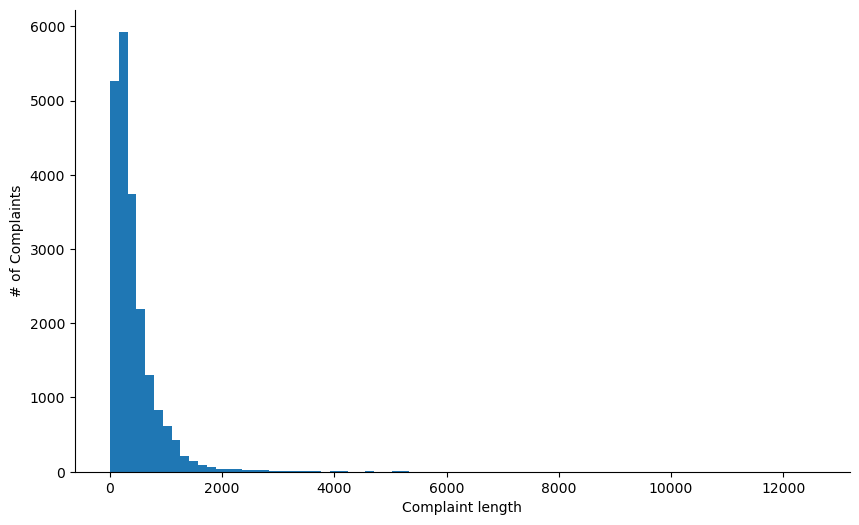

In [138]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 80)
plt.ylabel('# of Complaints')
plt.xlabel('Complaint length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

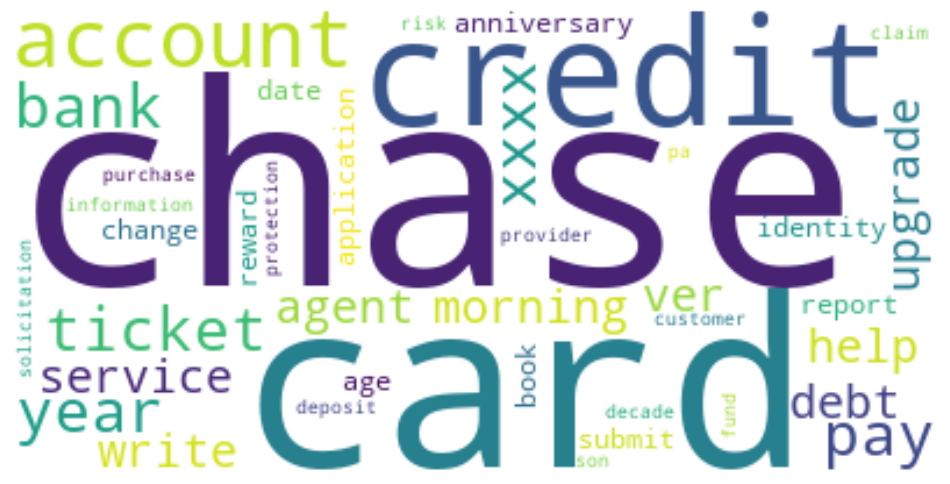

In [139]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(max_words=40, random_state=1, background_color='white', stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [140]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [141]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ajkrishn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [142]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['complaint_POS_removed'])
    count_values = grams.toarray().sum(axis=0)
    vocabulary = c_vec.vocabulary_
    df_xgram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocabulary.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_xgram

df_unigram = top_grams(1)
df_unigram.head(30)

,frequency,unigram
0,58460,chase
1,52900,xxxx
2,43065,account
3,33912,credit
4,30137,card
5,21329,payment
6,19978,bank
7,16233,time
8,15387,charge
9,13243,day


In [143]:
df_unigram = top_grams(3)
df_unigram.head(30)

,frequency,unigram
0,2275,chase credit card
1,1713,xxxx xxxx xxxx
2,1061,credit card account
3,977,credit card company
4,825,xxxx credit card
5,762,credit card chase
6,579,chase customer service
7,550,credit card xxxx
8,472,inquiry credit report
9,411,credit card credit


In [87]:
#Print the top 10 words in the unigram frequency
df_unigram = top_grams(1)
df_unigram.head(10)

,frequency,unigram
0,58460,chase
1,52900,xxxx
2,43065,account
3,33912,credit
4,30137,card
5,21329,payment
6,19978,bank
7,16233,time
8,15387,charge
9,13243,day


In [144]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
df_bigram = top_grams(2)
df_bigram.head(30)

,frequency,unigram
0,12862,credit card
1,6127,xxxx xxxx
2,3927,credit report
3,3170,chase credit
4,3004,customer service
5,2956,call chase
6,2579,chase bank
7,2507,account chase
8,2349,check account
9,2114,chase account


In [89]:
#Print the top 10 words in the bigram frequency
df_bigram = top_grams(2)
df_bigram.head(10)

,frequency,unigram
0,12862,credit card
1,6127,xxxx xxxx
2,3927,credit report
3,3170,chase credit
4,3004,customer service
5,2956,call chase
6,2579,chase bank
7,2507,account chase
8,2349,check account
9,2114,chase account


In [145]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
df_trigram = top_grams(3)
df_trigram.head(30)

,frequency,unigram
0,2275,chase credit card
1,1713,xxxx xxxx xxxx
2,1061,credit card account
3,977,credit card company
4,825,xxxx credit card
5,762,credit card chase
6,579,chase customer service
7,550,credit card xxxx
8,472,inquiry credit report
9,411,credit card credit


In [92]:
#Print the top 10 words in the trigram frequency
df_trigram = top_grams(3)
df_trigram.head(10)

,frequency,unigram
0,2275,chase credit card
1,1713,xxxx xxxx xxxx
2,1061,credit card account
3,977,credit card company
4,825,xxxx credit card
5,762,credit card chase
6,579,chase customer service
7,550,credit card xxxx
8,472,inquiry credit report
9,411,credit card credit


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [146]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [147]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_what_happened_lemme,cat,sub_cat,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,chase card report application submit identity ...
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,book ticket ticket reward card information off...
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple so...,Credit card or prepaid card,General-purpose credit card or charge card,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xx xx xxxx i called chas my xxx...,wednesday xx xx xxxx call chas xxxx xxxx v...,Credit card or prepaid card,General-purpose credit card or charge card,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account,Checking account,xxxx risk consumer chase year trust mobile ban...,risk consumer chase year trust mobile banking...
78311,i have had flawless credit for 30 yrs i ve ha...,flawless credit 30 yrs ve chase credit card ...,Credit card or prepaid card,General-purpose credit card or charge card,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [148]:
#Write your code here to initialise the TfidfVectorizer 

tfidf_vector=TfidfVectorizer(max_df=0.98,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [149]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_doc=tfidf_vector.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [150]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [151]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [152]:
nmf_model.fit(tfidf_doc)
len(tfidf_vector.get_feature_names_out())

6257

In [153]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TTop 15 words for the topic #{index} with tf-idf score')
    print([tfidf_vector.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

TTop 15 words for the topic #0 with tf-idf score
['claim', 'customer', 'transaction', 'business', 'number', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'money', 'bank', 'check', 'account']


TTop 15 words for the topic #1 with tf-idf score
['service', 'time', 'reason', 'application', 'month', 'point', 'purchase', 'year', 'limit', 'score', 'account', 'balance', 'chase', 'credit', 'card']


TTop 15 words for the topic #2 with tf-idf score
['date', 'statement', 'balance', 'property', 'rate', 'pay', 'year', 'time', 'home', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']


TTop 15 words for the topic #3 with tf-idf score
['dispute', 'letter', 'score', 'theft', 'remove', 'file', 'identity', 'account', 'reporting', 'debt', 'information', 'company', 'credit', 'inquiry', 'report']


TTop 15 words for the topic #4 with tf-idf score
['statement', 'time', 'email', 'contact', 'service', 'fraud', 'purchase', 'refund', 'claim', 'merchant', 'transaction', 'chase', 'fee', 

In [154]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_res = nmf_model.transform(tfidf_doc)
topic_res.argmax(axis=1)

array([0, 1, 3, ..., 3, 1, 2])

In [155]:
#Assign the best topic to each of the complaints in Topic Column

df_clean['Topic'] = topic_res.argmax(axis=1)

In [156]:
df_clean

,complaint_what_happened,complaint_what_happened_lemme,cat,sub_cat,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,1
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,chase card report application submit identity ...,3
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,book ticket ticket reward card information off...,3
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,0
...,...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple so...,Credit card or prepaid card,General-purpose credit card or charge card,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xx xx xxxx i called chas my xxx...,wednesday xx xx xxxx call chas xxxx xxxx v...,Credit card or prepaid card,General-purpose credit card or charge card,credit card provider claim purchase protection...,credit card provider claim purchase protection...,4
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account,Checking account,xxxx risk consumer chase year trust mobile ban...,risk consumer chase year trust mobile banking...,3
78311,i have had flawless credit for 30 yrs i ve ha...,flawless credit 30 yrs ve chase credit card ...,Credit card or prepaid card,General-purpose credit card or charge card,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,1


In [157]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,complaint_what_happened_lemme,cat,sub_cat,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,Vehicle loan or lease,Loan,mishandle account chase auto xxxx,mishandle account chase auto,0
17,with out notice j p morgan chase restricted m...,notice j p morgan chase restrict account deb...,Checking or savings account,Checking account,account debit card branch customer service rep...,account debit card branch customer service rep...,0
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,0
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus ...,Checking or savings account,Checking account,account call follow term account xxxx deposit ...,account call follow term account deposit bonu...,0
32,my chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,Credit card or prepaid card,General-purpose credit card or charge card,catering order place contact chase noon today ...,catering order place contact chase noon today ...,1
59,i currently have over xxxx chase ultimate rewa...,currently xxxx chase ultimate reward point w...,Credit card or prepaid card,General-purpose credit card or charge card,xxxx reward point month access chase reward ac...,reward point month access chase reward accoun...,1
52,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,Checking or savings account,Checking account,roommate chase debit card driver license money...,roommate chase debit card driver license money...,1
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,1
50,i am a senior citizen that has been scammed by...,senior citizen scamme company xxxx xxxx pay ...,Credit card or prepaid card,General-purpose credit card or charge card,citizen time share company refund credit card ...,citizen time share company refund credit card ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [160]:
#Create the dictionary of Topic names and Topics


Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic_category'] = df_clean['Topic'].map(Topic_names)


/var/folders/9s/5kjsxwbs7w7_bpyn162y53m80000gn/T/ipykernel_50088/583250386.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [161]:
df_clean

,complaint_what_happened,complaint_what_happened_lemme,cat,sub_cat,complaint_POS_removed,Complaint_clean,Topic,Topic_category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,0,Bank Account services
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,1,Credit card or prepaid card
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,chase card report application submit identity ...,3,Theft/Dispute Reporting
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,book ticket ticket reward card information off...,3,Theft/Dispute Reporting
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,0,Bank Account services
15,can you please remove inquiry,remove inquiry,"Credit reporting, credit repair services, or o...",Credit reporting,inquiry,inquiry,3,Theft/Dispute Reporting
17,with out notice j p morgan chase restricted m...,notice j p morgan chase restrict account deb...,Checking or savings account,Checking account,account debit card branch customer service rep...,account debit card branch customer service rep...,0,Bank Account services
20,during the summer months i experience a decli...,summer month experience decline income emplo...,Vehicle loan or lease,Loan,summer month experience income employment requ...,summer month experience income employment requ...,2,Others
21,on xxxx xx xx 2019 i made a 300 00 payment...,xxxx xx xx 2019 300 00 payment online r...,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,payment retailer chase pay xxxx chase website ...,payment retailer chase pay chase website scam...,4,Mortgage/Loan
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,Credit card or prepaid card,General-purpose credit card or charge card,chase credit card datum credit report company ...,chase credit card datum credit report company ...,3,Theft/Dispute Reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [162]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [163]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,1
10,chase card was reported on xx xx 2019 however...,3
11,on xx xx 2018 while trying to book a xxxx xx...,3
14,my grand son give me check for 1600 00 i de...,0
15,can you please remove inquiry,3
17,with out notice j p morgan chase restricted m...,0
20,during the summer months i experience a decli...,2
21,on xxxx xx xx 2019 i made a 300 00 payment...,4
23,i have a chase credit card which is incorrectl...,3


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



